In [2]:
# 导入工具包
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class EEGNet(nn.Module):
    def __init__(self, classes_num):
        super(EEGNet, self).__init__()
        self.drop_out = 0.25
        self.block_1 = nn.Sequential(
            # Pads the input tensor boundaries with zero
            # left, right, up, bottom
            nn.ZeroPad2d((31, 32, 0, 0)),
            nn.Conv2d(
                in_channels=1,  # input shape (1, C, T)
                out_channels=8,  # num_filters
                kernel_size=(1, 64),  # filter size
                bias=False
            ),  # output shape (8, C, T)
            nn.BatchNorm2d(8)  # output shape (8, C, T)
        )
        # block 2 and 3 are implementations of Depthwise Convolution and Separable Convolution
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,  # input shape (8, C, T)
                out_channels=16,  # num_filters
                kernel_size=(22, 1),  # filter size
                groups=8,
                bias=False
            ),  # output shape (16, 1, T)
            nn.BatchNorm2d(16),  # output shape (16, 1, T)
            nn.ELU(),
            nn.AvgPool2d((1, 4)),  # output shape (16, 1, T//4)
            nn.Dropout(self.drop_out)  # output shape (16, 1, T//4)
        )
        self.block_3 = nn.Sequential(
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,  # input shape (16, 1, T//4)
                out_channels=16,  # num_filters
                kernel_size=(1, 16),  # filter size
                groups=16,
                bias=False
            ),  # output shape (16, 1, T//4)
            nn.Conv2d(
                in_channels=16,  # input shape (16, 1, T//4)
                out_channels=16,  # num_filters
                kernel_size=(1, 1),  # filter size
                bias=False
            ),  # output shape (16, 1, T//4)
            nn.BatchNorm2d(16),  # output shape (16, 1, T//4)
            nn.ELU(),
            nn.AvgPool2d((1, 8)),  # output shape (16, 1, T//32)
            nn.Dropout(self.drop_out)
        )

        self.out = nn.Linear((864), classes_num)

    def forward(self, x):
        x = self.block_1(x)
        print("block1", x.shape)
        x = self.block_2(x)
        print("block2", x.shape)
        x = self.block_3(x)
        print("block3", x.shape)

        x = x.view(x.size(0), -1)
        x = self.out(x)
        return F.softmax(x, dim=1), x  # return x for visualization
    
model=EEGNet(classes_num=2)
model = model.cuda()
from torchsummary import summary
summary(model, input_size=(1, 30, 200))







block1 torch.Size([2, 8, 30, 200])
block2 torch.Size([2, 16, 9, 50])
block3 torch.Size([2, 16, 9, 6])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1           [-1, 1, 30, 263]               0
            Conv2d-2           [-1, 8, 30, 200]             512
       BatchNorm2d-3           [-1, 8, 30, 200]              16
            Conv2d-4           [-1, 16, 9, 200]             352
       BatchNorm2d-5           [-1, 16, 9, 200]              32
               ELU-6           [-1, 16, 9, 200]               0
         AvgPool2d-7            [-1, 16, 9, 50]               0
           Dropout-8            [-1, 16, 9, 50]               0
         ZeroPad2d-9            [-1, 16, 9, 65]               0
           Conv2d-10            [-1, 16, 9, 50]             256
           Conv2d-11            [-1, 16, 9, 50]             256
      BatchNorm2d-12            [-1, 16, 9, 50]              32
 

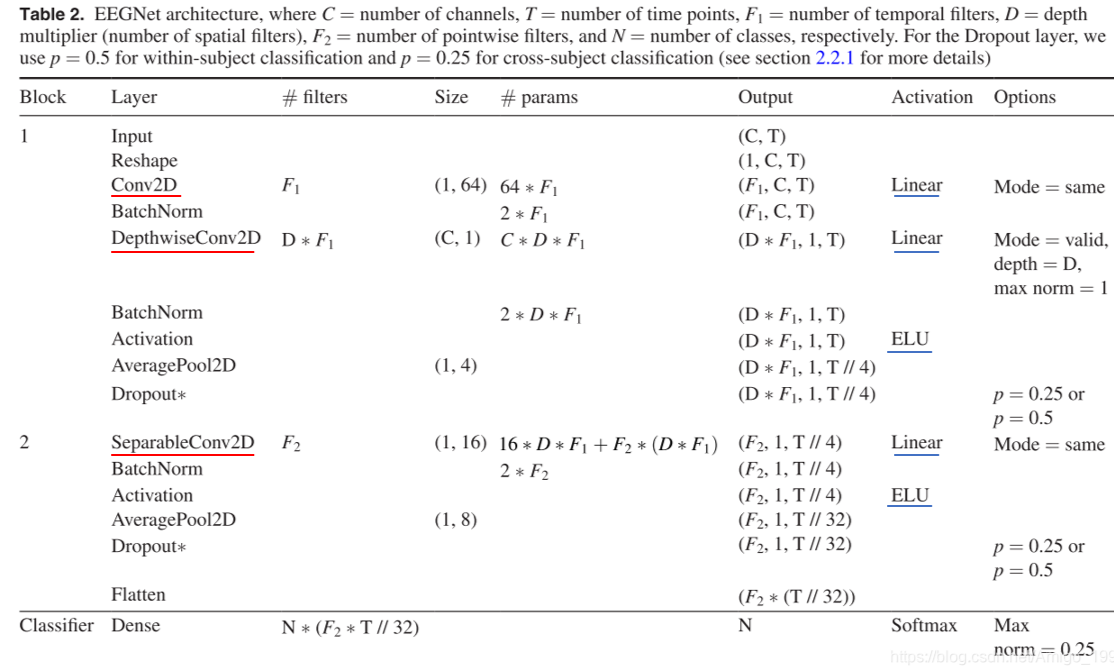